In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [177]:
variable_info = [
    # Firm Variables
    Variable(name="Y", dims="i", description="Total output of good <dim:i>"),
    Variable(name="VA", dims="i", description="Labor-capital bundle produced by sector <dim:i>"),
    Variable(
        name="VC", dims="i", description="Intermediate goods bundle produced by sector <dim:i>"
    ),
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for sector <dim:i> goods by sector <dim:j>",
    ),
    Variable(
        name="L_d",
        dims="i",
        extend_subscript=True,
        description="Labor demanded by sector <dim:i>",
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demanded by sector <dim:i>",
    ),
    Variable(name="L_s", description="Household labor supply"),
    # Household Variables
    Variable(name="U", description="Household utility"),
    Variable(name="C", dims="i", description="Household consumption of good <dim:i>"),
    Variable(name="C_total", latex_name="\bar{C}", description="Household consumption bundle"),
    Variable(name="income", latex_name="Omega", description="Total household income"),
    # Prices
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    Variable(name="CPI", latex_name="P_C", description="Price of the household consumption basket"),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the labor-capital bundle in sector <dim:i>",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the intermediate bundle in sector <dim:i>",
    ),
    Variable(name="P", dims="i", description="Price level of final goods in sector <dim:i>"),
    # Other
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]

param_info = [
    # Firm Parameters
    Parameter(
        name="psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of labor-capital in sector <dim:i>'s final good",
    ),
    Parameter(
        name="psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of intermediate goods bundle in sector <dim:i>'s final product",
    ),
    Parameter(
        name="psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of sector <dim:i>'s final good in sector <dim:j>'s value chain bundle",
    ),
    Parameter(
        name="alpha",
        dims="i",
        description="Share of capital in sector <dim:i>'s production process",
    ),
    Parameter(
        name="phi_VA",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",
    ),
    Parameter(name="A", dims="i", description="Total factor productivity in sector <dim:i>"),
    # Household Parameters
    Parameter(
        name="sigma_C",
        description="Arrow-Pratt risk averson",
    ),
    Parameter(name="sigma_L", description="Inverse Frisch elasticity between work and leisure"),
    Parameter(name="Theta", description="Household labor dispreference parameter"),
    Parameter(name="phi_C", description="Elasticity of substitution between consumption goods"),
    Parameter(
        name="alpha_C",
        dims="i",
        extend_subscript=True,
        description="Share of <dim:i> in the household consumption bundle",
    ),
    Parameter(name="A_C", description="Household shopping technology"),
    # Exogenous variables
    Parameter(name="K_s", description="Exogenous household capital stock"),
    Parameter(
        name="P_bar",
        latex_name=r"\bar{P}",
        description="Exogenous CPI price level",
    ),
]

equations = [
    # # Firm Equations
    # Final Goods
    Equation("Final good production of sector <dim:i>", "P * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for labor-capital", "VA = psi_VA * Y"),
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        "VC * P_VC = (P[:, None] * X).sum(axis=0).ravel()",
    ),
    Equation("Sector <dim:i> demand for sector <dim:j> intermediate input", "X = psi_X * VC[None]"),
    # Value add bundle
    Equation(
        "Sector <dim:i> production of labor-capital",
        "VA = A * (alpha * KE_d**((phi_VA - 1) / phi_VA) +"
        "(1 - alpha) * L_d**((phi_VA - 1) / phi_VA)) ** (phi_VA / (phi_VA - 1))",
    ),
    Equation(
        "Sector <dim:i> demand for capital", "K_d = VA / A * (alpha * P_VA * A / r) ** phi_VA"
    ),
    Equation(
        "Sector <dim:i> demand for labor",
        "L_d = VA / A * ((1 - alpha) * A * P_VA / w) ** phi_VA",
    ),
    # # Household Equations
    Equation("Household income", "income = w * L_s + r * K_s"),
    Equation(
        "Household utility",
        "U = C_total ** (1 - sigma_C) / (1 - sigma_C) - Theta * L_s ** (1 + sigma_L) / (1 + sigma_L)",
    ),
    Equation(
        "Household shopping function",
        "C_total = A_C * (alpha_C * C ** ((phi_C - 1) / phi_C)).sum() ** (phi_C / (phi_C - 1))",
    ),
    Equation(
        "Household demand for good <dim:i>",
        "C = C_total / A_C * (alpha_C * A_C * CPI / P) ** phi_C",
    ),
    Equation("CPI level", "1 = (alpha_C * P ** (1 - phi_C)).sum()"),
    Equation("Household supply of labor", "L_s ** sigma_L * C_total ** sigma_C = w / Theta"),
    # # Market clearning conditions
    Equation("Labor market clearing", "L_s = L_d.sum() + resid"),
    Equation("Capital market clearing", "K_s = K_d.sum()"),
    Equation("Sector <dim:i> goods market clearing", "Y = C + X.sum(axis=1)"),
    Equation("Numeraire", "CPI = P_bar"),
]

In [178]:
sectors = ["Ag", "Ind", "Serv"]
n_sectors = len(sectors)
coords = {"i": sectors, "j": sectors}

mod = CGEModel(
    variables=variable_info,
    parameters=param_info,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=False,
    backend="pytensor",
    mode="JAX",
)

In [179]:
data = np.array(
    [
        [0, 0, 0, 1000, 2000, 4000],
        [0, 0, 0, 500, 2000, 500],
        [7000, 3000, 0, 0, 0, 0],
        [0, 0, 2000, 1000, 1000, 1000],
        [0, 0, 2500, 2000, 3500, 3000],
        [0, 0, 5500, 500, 2500, 1000],
    ]
)

cols = ["L_d", "K_d", "Men", "Ag", "Ind", "Serv"]
df = pd.DataFrame(data, columns=cols, index=cols, dtype="float64")

In [249]:
data = {
    "L_d": df.loc["L_d", sectors].values,
    "K_d": df.loc["K_d", sectors].values,
    "X": df.loc[sectors, sectors].values,
    "Y": df.loc[sectors, :].values.sum(axis=1),
    "phi_VA": np.full(n_sectors, 3.0),
    "phi_C": 100,
    "sigma_C": 1.5,
    "sigma_L": 3.0,
    "Theta": 1,
    "P": np.ones((n_sectors,)),
    "P_VA": np.ones((n_sectors,)),
    "P_VC": np.ones((n_sectors,)),
    "r": 1.0,
    "w": 1.0,
    "P_bar": 1.0,
}

In [250]:
def calibrate_model(
    L_d, K_d, Y, X, P, P_VA, P_VC, r, w, sigma_C, sigma_L, Theta, phi_VA, phi_C, P_bar
):
    calib_dict = {
        "L_d": L_d,
        "K_d": K_d,
        "Y": Y,
        "X": X,
        "P": P,
        "r": r,
        "w": w,
        "P_VA": P_VA,
        "P_VC": P_VC,
        "phi_VA": phi_VA,
        "phi_C": phi_C,
        "sigma_C": sigma_C,
        "sigma_L": sigma_L,
        "P_bar": P_bar,
    }

    rho_VA = (phi_VA - 1) / phi_VA
    rho_C = (phi_C - 1) / phi_C

    # Numeraire
    resid = 0.0
    CPI = P_bar

    # Household calibration
    L_s = L_d.sum()
    K_s = K_d.sum()
    income = w * L_s + r * K_s
    C = Y - X.sum(axis=1)

    alpha_C = P * C ** (1 / phi_C) / (P * C ** (1 / phi_C)).sum()
    A_C = C.sum() * (alpha_C * C**rho_C).sum() ** (-1 / rho_C)
    C_total = A_C * (alpha_C * C ** ((phi_C - 1) / phi_C)).sum() ** (phi_C / (phi_C - 1))

    Theta = 1
    sigma_L = (np.log(w / Theta) - sigma_C * np.log(C_total)) / np.log(L_s)

    U = C_total ** (1 - sigma_C) / (1 - sigma_C) - Theta * L_s ** (1 + sigma_L) / (1 + sigma_L)

    # Firm calibration
    VA = (w * L_d + r * K_d) / P_VA
    VC = (P[:, None] * X).sum(axis=0) / P_VC

    alpha = r * K_d ** (1 / phi_VA) / ((r * K_d ** (1 / phi_VA) + w * L_d ** (1 / phi_VA)))
    A = VA * (alpha * K_d**rho_VA + (1 - alpha) * L_d**rho_VA) ** (-1 / rho_VA)

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_X = X / VC[None]

    calib_dict["VA"] = VA
    calib_dict["VC"] = VC
    calib_dict["psi_VC"] = psi_VC
    calib_dict["psi_VA"] = psi_VA
    calib_dict["psi_X"] = psi_X
    calib_dict["alpha"] = alpha
    calib_dict["A"] = A

    calib_dict["income"] = income
    calib_dict["C_total"] = income
    calib_dict["C"] = C
    calib_dict["U"] = U
    calib_dict["L_s"] = L_s
    calib_dict["alpha_C"] = alpha_C
    calib_dict["A_C"] = A_C
    calib_dict["Theta"] = Theta
    calib_dict["sigma_L"] = sigma_L

    # Exogenous
    calib_dict["K_s"] = K_s
    calib_dict["resid"] = resid
    calib_dict["CPI"] = P_bar

    return calib_dict

In [252]:
calibrated_data = calibrate_model(**data)
mod.check_for_equilibrium(calibrated_data)

Equilibrium found! Total squared error: 0.000000


In [253]:
wage_increase = calibrated_data.copy()
wage_increase["K_s"] = 4000
theta_wage_increase = np.r_[
    *[np.atleast_1d(wage_increase[x]).flatten() for x in mod.parameter_names]
]
n_steps = 10_000
idata = mod._solve_with_euler_approximation(
    calibrated_data, theta_final=theta_wage_increase, n_steps=n_steps
)

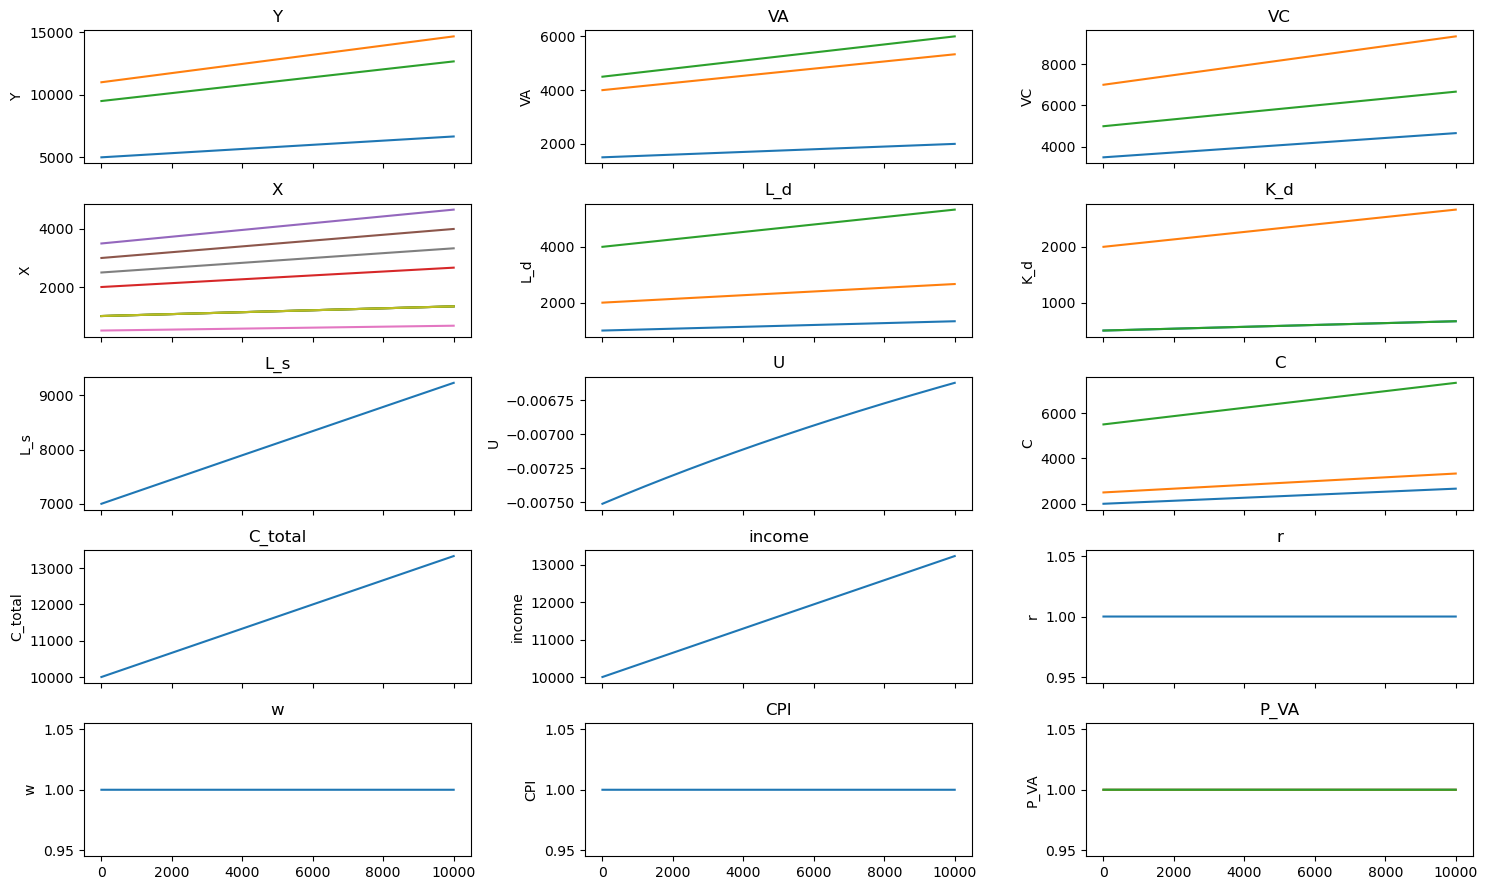

In [254]:
fig, ax = plt.subplots(5, 3, figsize=(15, 9), sharex=True)
for i, (axis, var) in enumerate(zip(fig.axes, mod.variable_names)):
    data = idata.variables[var]
    if data.ndim > 2:
        data = data.stack(pair=["i", "j"])
    data.plot.line(x="step", ax=axis, add_legend=False)
    axis.set(title=var, xlabel=None)

#     scatter_grid = np.full(int(np.prod(res_d[var].shape)), idata.variables.coords["step"].max())
#     axis.scatter(scatter_grid, res_d[var].ravel(), marker="*", color="tab:red", zorder=10, s=100)
fig.tight_layout()